# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

In [5]:
!nvidia-smi

Sun May 31 12:11:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# !nvidia-smi daemon -d 20 -p gpu_usage.txt

# Mounting Google Drive in your VM

The example below shows how to mount your Google Drive in your virtual machine using an authorization code, and shows a couple of ways to write & read files there. Once executed, observe the new file (`foo.txt`) is visible in https://drive.google.com/

Note this only supports reading and writing files.

In [0]:
from google.colab import drive
drive.mount('/gdrive')

# Install detectron2

In [0]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [0]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

In [10]:
# !pip install -U torch torchvision
# !pip install git+https://github.com/facebookresearch/fvcore.git
import torch
import torchvision
torch.__version__

'1.5.0+cu101'

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [0]:
from detectron2.data.datasets import register_coco_instances
import os

In [0]:
# DATA_PATH = '/gdrive/My Drive/cell_segmentation/data/coco_data3/'
DATA_PATH3_1 = '/gdrive/My Drive/cell_segmentation/data/coco_data3_1/'
# _test_jsn, _test_dir = "{}test.json".format(DATA_PATH), "{}test".format(DATA_PATH)
_test_jsn, _test_dir = "{}test.json".format(DATA_PATH3_1), "{}test".format(DATA_PATH3_1)
# _train_jsn, _train_dir = "{}train.json".format(DATA_PATH), "{}train".format(DATA_PATH)
_train_dir = "{}train_augmented".format(DATA_PATH3_1)
_train_jsn = "{}/annotation.json".format(_train_dir)

if os.path.exists(_train_dir) and os.path.exists(_train_jsn):
  register_coco_instances("train_cells", {}, _train_jsn, _train_dir)
else:
  print('fuck you')

if os.path.exists(_test_dir) and os.path.exists(_test_jsn):
  register_coco_instances("test_cells", {}, _test_jsn, _test_dir)
else:
  print('fuck you too')

# if os.path.exists(_test_dir3_1) and os.path.exists(_test_jsn3_1):
#   register_coco_instances("test_cells3_1", {}, _test_jsn3_1, _test_dir3_1)
# else:
#   print('fuck you too yaa')

In [14]:
train_metadata = MetadataCatalog.get("train_cells")
train_dicts = DatasetCatalog.get("train_cells")

test_metadata = MetadataCatalog.get("test_cells")
test_dicts = DatasetCatalog.get("test_cells")

# test_metadata3_1 = MetadataCatalog.get("test_cells3_1")
# test_dicts3_1 = DatasetCatalog.get("test_cells3_1")

[05/31 12:12:55 d2.data.datasets.coco]: Loading /gdrive/My Drive/cell_segmentation/data/coco_data3_1/train_augmented/annotation.json takes 1.80 seconds.
WARNING [05/31 12:12:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/31 12:12:55 d2.data.datasets.coco]: Loaded 2329 images in COCO format from /gdrive/My Drive/cell_segmentation/data/coco_data3_1/train_augmented/annotation.json
WARNING [05/31 12:12:56 d2.data.datasets.coco]: Filtered out 36 instances without valid segmentation. There might be issues in your dataset generation process.
WARNING [05/31 12:12:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/31 12:12:56 d2.data.datasets.coco]: Loaded 57 images in COCO format from /gdrive/My Drive/cell_segmentation/data/coco_data3_1/test.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



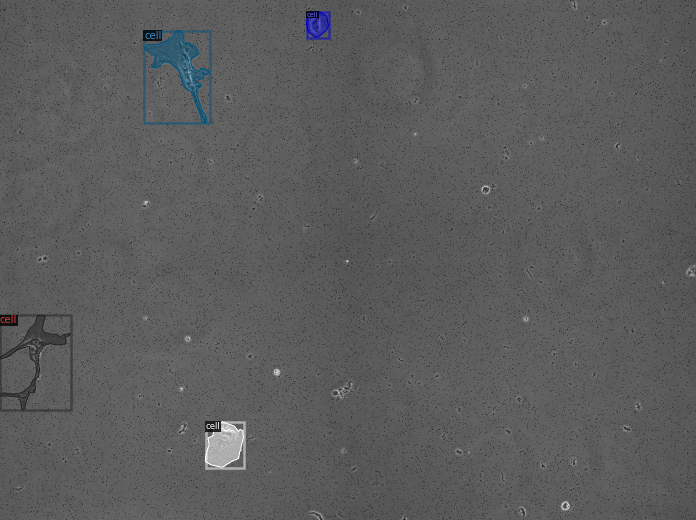

In [15]:
import random

for d in random.sample(train_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [0]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.OUTPUT_DIR = '/gdrive/My Drive/R101_output_data_aug'

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("train_cells",)
cfg.DATASETS.TEST = ("test_cells")   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.CHECKPOINT_PERIOD = 5000

# cfg.MODEL.WEIGHTS = "/gdrive/My Drive/model_0009999.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.TEST.AUG.ENABLED = True

cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 3 classes (data, fig, hazelnut)

## Train!

In [0]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[05/30 20:45:21 d2.utils.events]:  eta: 5:34:02  iter: 19  total_loss: 2.580  loss_cls: 0.812  loss_box_reg: 0.243  loss_mask: 0.691  loss_rpn_cls: 0.681  loss_rpn_loc: 0.179  time: 2.0766  data_time: 0.9177  lr: 0.000002  max_mem: 11407M
[05/30 20:46:04 d2.utils.events]:  eta: 5:33:13  iter: 39  total_loss: 2.260  loss_cls: 0.533  loss_box_reg: 0.196  loss_mask: 0.689  loss_rpn_cls: 0.679  loss_rpn_loc: 0.169  time: 2.1174  data_time: 0.9621  lr: 0.000004  max_mem: 11407M
[05/30 20:46:44 d2.utils.events]:  eta: 5:34:10  iter: 59  total_loss: 2.220  loss_cls: 0.427  loss_box_reg: 0.269  loss_mask: 0.685  loss_rpn_cls: 0.674  loss_rpn_loc: 0.158  time: 2.0833  data_time: 0.7931  lr: 0.000006  max_mem: 11407M
[05/30 20:47:26 d2.utils.events]:  eta: 5:35:38  iter: 79  total_loss: 2.161  loss_cls: 0.400  loss_box_reg: 0.268  loss_mask: 0.679  loss_rpn_cls: 0.660  loss_rpn_loc: 0.185  time: 2.0883  data_time: 0.8895  lr: 0.000008  max_mem: 11407M
[05/30 20:48:06 d2.utils.events]:  eta: 5:36

KeyError: ignored

In [8]:
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 16000
cfg.SOLVER.CHECKPOINT_PERIOD = 2000

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[05/31 10:07:25 d2.data.datasets.coco]: Loading /gdrive/My Drive/cell_segmentation/data/coco_data3_1/train_augmented/annotation.json takes 2.43 seconds.
WARNING [05/31 10:07:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/31 10:07:25 d2.data.datasets.coco]: Loaded 2329 images in COCO format from /gdrive/My Drive/cell_segmentation/data/coco_data3_1/train_augmented/annotation.json
WARNING [05/31 10:07:25 d2.data.datasets.coco]: Filtered out 36 instances without valid segmentation. There might be issues in your dataset generation process.
[05/31 10:07:25 d2.data.build]: Removed 0 images with no usable annotations. 2329 images left.
[05/31 10:07:25 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 34134        |
|            |              |
[05/31 10:07:25 d2.data.common]: Serializing 2329 elements to byte tensors and concatena

KeyboardInterrupt: ignored

## Tensorboard

In [1]:
# Look at training curves in tensorboard:
%load_ext tensorboard

%tensorboard --logdir /gdrive/My\ Drive/R101_output_data_aug

Output hidden; open in https://colab.research.google.com to view.

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0011999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("test_cells")
cfg.TEST.AUG.ENABLED = True
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

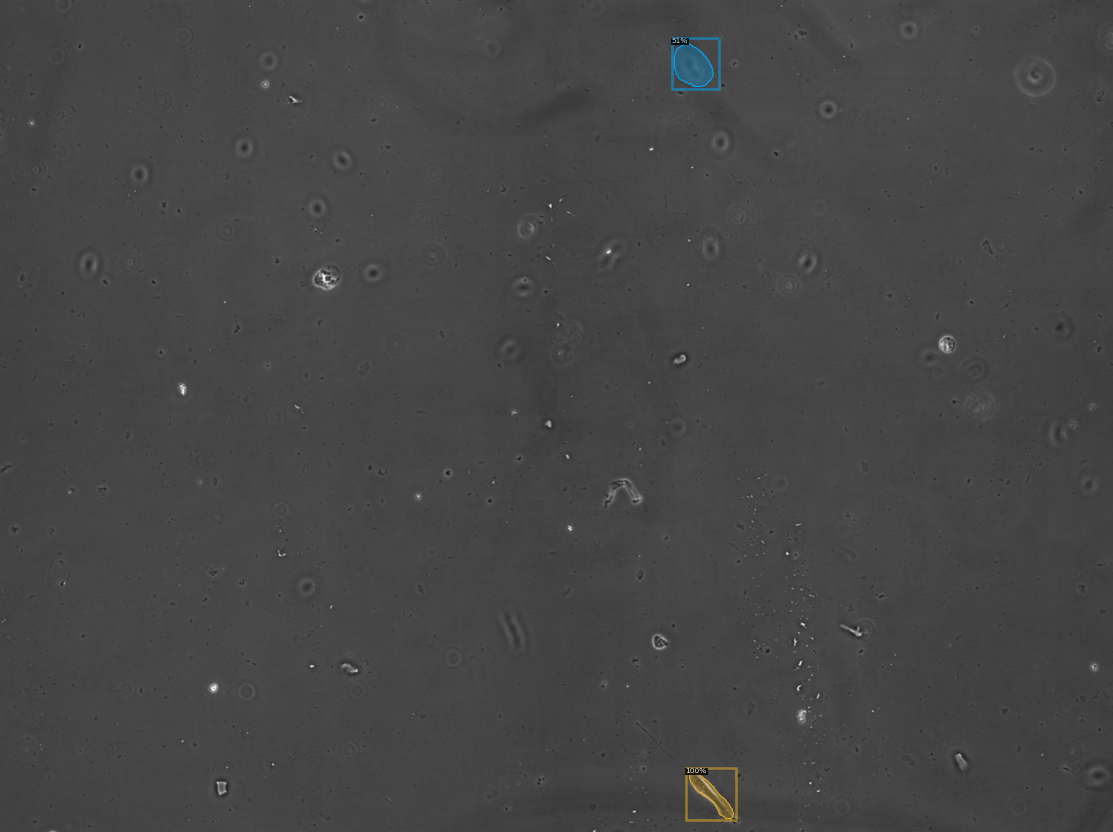

In [20]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

## Benchmark inference speed

In [17]:
import time
times = []
for i,d in enumerate(random.sample(test_dicts, 20)):  
    start_time = time.time()
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):1.29,fps:0.78


## Error in COCO and decision
https://github.com/cocodataset/cocoapi/issues/49
/usr/local/lib/python3.6/dist-packages/pycocotools/coco.py

In [19]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("test_cells", cfg, False, output_dir="./output_test/")
val_loader = build_detection_test_loader(cfg, "test_cells")

inference_on_dataset(predictor.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

# R101 11000 not aug
# OrderedDict([('bbox',
#               {'AP': 21.255492914858078,
#                'AP50': 52.867518924131,
#                'AP75': 14.279746960358105,
#                'APl': 7.311706733282171,
#                'APm': 25.099239164432934,
#                'APs': 15.866360391695277}),
#              ('segm',
#               {'AP': 17.933251118133104,
#                'AP50': 49.90429538583633,
#                'AP75': 7.505001686849626,
#                'APl': 19.14908337298024,
#                'APm': 19.223375419189168,
#                'APs': 7.241339450541203})])



# R101 13000 pre-aug
# OrderedDict([('bbox',
#               {'AP': 22.56575703113507,
#                'AP50': 53.0681028859366,
#                'AP75': 15.398148208273332,
#                'APl': 8.801040238549703,
#                'APm': 26.032764088782855,
#                'APs': 17.815635590270364}),
#              ('segm',
#               {'AP': 18.85936769166157,
#                'AP50': 50.603793201327164,
#                'AP75': 9.11671939273895,
#                'APl': 18.01077437126209,
#                'APm': 20.185193752808868,
#                'APs': 7.886567506213327})])

# R101 5000 aug
# OrderedDict([('bbox',
#               {'AP': 15.510833355604264,
#                'AP50': 39.42615211879254,
#                'AP75': 8.693679145194071,
#                'APl': 2.6321458188283042,
#                'APm': 19.830391503443177,
#                'APs': 9.900990099009901}),
#              ('segm',
#               {'AP': 8.565823913464609,
#                'AP50': 29.57790945254016,
#                'AP75': 1.1743054004648585,
#                'APl': 7.467231981637397,
#                'APm': 9.621596550461934,
#                'APs': 1.62620443283342})])

# R101 10000 aug
# OrderedDict([('bbox',
#               {'AP': 16.960673460561086,
#                'AP50': 44.75522209413631,
#                'AP75': 9.642056596156038,
#                'APl': 3.6388399520057306,
#                'APm': 20.895627582937674,
#                'APs': 13.861386138613863}),
#              ('segm',
#               {'AP': 10.521222391056,
#                'AP50': 35.318669620827954,
#                'AP75': 2.5107948023934727,
#                'APl': 9.282691315714969,
#                'APm': 11.42053382398132,
#                'APs': 3.9469358758102366})])

# R101 12000 aug
# OrderedDict([('bbox',
#               {'AP': 16.650329112214983,
#                'AP50': 44.3223946431427,
#                'AP75': 9.971346519822594,
#                'APl': 5.256634971574785,
#                'APm': 19.45821298694141,
#                'APs': 13.06930693069307}),
#              ('segm',
#               {'AP': 10.824691207507055,
#                'AP50': 36.038732776901924,
#                'AP75': 2.556007537407656,
#                'APl': 10.123334483466582,
#                'APm': 11.896075422928593,
#                'APs': 3.076549258653004})])

WARNING [05/31 12:13:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/31 12:13:41 d2.data.datasets.coco]: Loaded 57 images in COCO format from /gdrive/My Drive/cell_segmentation/data/coco_data3_1/test.json
[05/31 12:13:41 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 722          |
|            |              |
[05/31 12:13:41 d2.data.common]: Serializing 57 elements to byte tensors and concatenating them all ...
[05/31 12:13:41 d2.data.common]: Serialized dataset takes 0.36 MiB
[05/31 12:13:41 d2.evaluation.evaluator]: Start inference on 57 images
[05/31 12:13:47 d2.evaluation.evaluator]: Inference done 11/57. 0.4634 s / img. ETA=0:00:23
[05/31 12:13:52 d2.evaluation.evaluator]: Inference done 21/57. 0.4618 s / img. ETA=0:00:18
[05/31 12:13:57 d2.evaluation.evaluator]: Inference done 31/57. 0.4629 s / img. ETA=0:00:13
[0

OrderedDict([('bbox',
              {'AP': 16.650329112214983,
               'AP50': 44.3223946431427,
               'AP75': 9.971346519822594,
               'APl': 5.256634971574785,
               'APm': 19.45821298694141,
               'APs': 13.06930693069307}),
             ('segm',
              {'AP': 10.824691207507055,
               'AP50': 36.038732776901924,
               'AP75': 2.556007537407656,
               'APl': 10.123334483466582,
               'APm': 11.896075422928593,
               'APs': 3.076549258653004})])

In [0]:
evaluator = COCOEvaluator("train_cells", cfg, False, output_dir="./output_test_train/")
val_loader = build_detection_test_loader(cfg, "train_cells")

inference_on_dataset(predictor.model, val_loader, evaluator)

In [0]:
!cp /gdrive/My\ Drive/adaptis_toy.tar ./
!tar xf adaptis_toy.tar

In [0]:
import cv2
import matplotlib.pyplot as plt


In [0]:
im = cv2.imread('adaptis_toy/original/test/00000_im.png')
rgb = cv2.imread('adaptis_toy/original/test/00000_rgb.png')


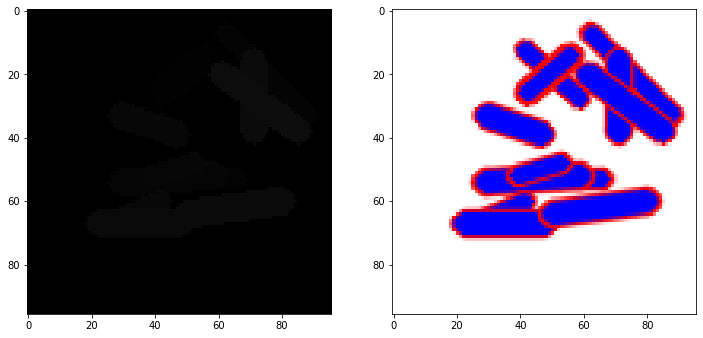

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(im)

plt.subplot(122)
plt.imshow(rgb)

In [36]:
np.unique(im)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8)